# Problem 1

1. What is the market pricing to occur to the Federal Funds rate by end of next year?

The current Dec 2026 Fed Funds futures contract is trading at 96.74 which implies a fed funds rate of 3.26% (100 - 96.74) by the end of next year. This means that the market is pricing in ~ 4.3 cuts.

Calculation: 
- EFFR usually trades ≈ 5 bp below the mid‑point
- current Fed Funds midpoint is 4.375%
- (4.375 % - (3.26 + .05) %) / .25 = 4.3 cuts

# Problem 2

In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

FILE1             = "Assignment_2_data.xlsm"
FILE2             = "macro_data.xlsx"
FILE3             = "macro_data_TR-fixed.xlsx"
HORIZON_MONTHS    = 18     # window length in months
START_DATE        = "1995-01-03"
END_DATE          = '2025-03-01'
DECLINE_THRESHOLD = 0.5   # minimum rate drop 

In [2]:
# Fed Funds (EFFR)
fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed.rename(columns={'Rate': 'PX_Last'}, inplace=True)
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window

# S&P 500 Price Index
spx = pd.read_excel(FILE1, sheet_name='SPTX', index_col='Date')
spx.rename(columns={'Price': 'PX_Last'}, inplace=True)
spx = spx[~spx.index.duplicated(keep='last')]

treasury = pd.read_excel(FILE3, sheet_name='LUATTRUU', index_col='Date')
treasury = treasury[~treasury.index.duplicated(keep='last')]


hy = pd.read_excel(FILE3, sheet_name='H0A0', index_col='Date')
hy = hy[~hy.index.duplicated(keep='last')]

# Commodities & Gold
commodities = pd.read_excel(FILE3, sheet_name='BCOMTR', index_col='Date')
commodities = commodities[~commodities.index.duplicated(keep='last')]

gold = pd.read_excel(FILE2, sheet_name='Gold', index_col='Date')
gold = gold[~gold.index.duplicated(keep='last')]

In [3]:
asset_px = pd.concat({
    'SPX'        : spx['PX_Last'],
    'treasury'        : treasury['PX_Last'],
    'HY'         : hy['PX_Last'],
    'Commodities': commodities['PX_Last'],
    'Gold'       : gold['PX_Last']
}, axis=1).ffill()

# align & trim Fed Funds to match asset dates
ff_rate = fed['PX_Last'].reindex(asset_px.index).ffill()

# apply START_DATE cutoff
asset_px = asset_px[asset_px.index >= pd.to_datetime(START_DATE)]
ff_rate  = ff_rate[ ff_rate.index  >= pd.to_datetime(START_DATE)]

# apply END_DATE cutoff
asset_px = asset_px[asset_px.index <= pd.to_datetime(END_DATE)]
ff_rate  = ff_rate[ ff_rate.index  <= pd.to_datetime(END_DATE)]


In [4]:
regimes = []
for t0 in ff_rate.index:
    # determine the actual end-date at least HORIZON_MONTHS ahead
    t1_target = t0 + relativedelta(months=+HORIZON_MONTHS)
    possible_ends = ff_rate.index[ff_rate.index >= t1_target]
    if possible_ends.empty:
        continue
    t1 = possible_ends[0]
    drop = ff_rate.loc[t0] - ff_rate.loc[t1]
    # require minimum drop and non-overlap
    if drop >= DECLINE_THRESHOLD:
        if not regimes or t0 >= regimes[-1] + relativedelta(months=+HORIZON_MONTHS):
            regimes.append(t0)

print(f"Found {len(regimes)} windows where EFFR fell ≥{DECLINE_THRESHOLD} ppt over {HORIZON_MONTHS} months:")
for d0 in regimes:
    possible_ends = ff_rate.index[ff_rate.index >= d0 + relativedelta(months=+HORIZON_MONTHS)]
    d1 = possible_ends[0] if not possible_ends.empty else None
    if d1 is not None:
        drop = ff_rate.loc[d0] - ff_rate.loc[d1]
        print(f"  {d0.date()} → {d1.date()}   (drop: {drop:.2f} ppt)")

Found 10 windows where EFFR fell ≥0.5 ppt over 18 months:
  1995-03-01 → 1996-09-02   (drop: 0.69 ppt)
  1997-05-28 → 1998-11-30   (drop: 0.70 ppt)
  1999-11-30 → 2001-05-30   (drop: 0.61 ppt)
  2001-05-30 → 2002-11-30   (drop: 3.05 ppt)
  2002-11-30 → 2004-05-31   (drop: 0.76 ppt)
  2006-06-29 → 2007-12-31   (drop: 0.71 ppt)
  2007-12-31 → 2009-06-30   (drop: 4.01 ppt)
  2018-10-01 → 2020-04-01   (drop: 1.32 ppt)
  2020-04-01 → 2021-10-01   (drop: 0.55 ppt)
  2023-07-03 → 2025-01-03   (drop: 0.59 ppt)


In [5]:
records = []
for d0 in regimes:
    # find actual asset end-date
    future = asset_px.index[asset_px.index >= d0 + relativedelta(months=+HORIZON_MONTHS)]
    if future.empty or d0 not in asset_px.index:
        continue
    d1 = future[0]
    ret = asset_px.loc[d1] / asset_px.loc[d0] - 1
    # add coupon carry
    months = HORIZON_MONTHS
    ret.name = d0
    records.append(ret)

reg_df = pd.DataFrame(records).dropna(axis=0, how='any')

stats = pd.DataFrame({
    'mean_ret': reg_df.mean(),
    'vol'     : reg_df.std()
})
stats['sharpe'] = stats['mean_ret'] / stats['vol'].replace(0, np.nan)
stats.index.name = 'Asset'

print("\n=== PERFORMANCE OVER WINDOWS ===")
print(stats.round(3).sort_values('mean_ret', ascending=False))


=== PERFORMANCE OVER WINDOWS ===
             mean_ret    vol  sharpe
Asset                               
SPX             0.159  0.355   0.446
Gold            0.156  0.187   0.831
treasury        0.107  0.073   1.474
Commodities     0.107  0.343   0.313
HY              0.105  0.139   0.761


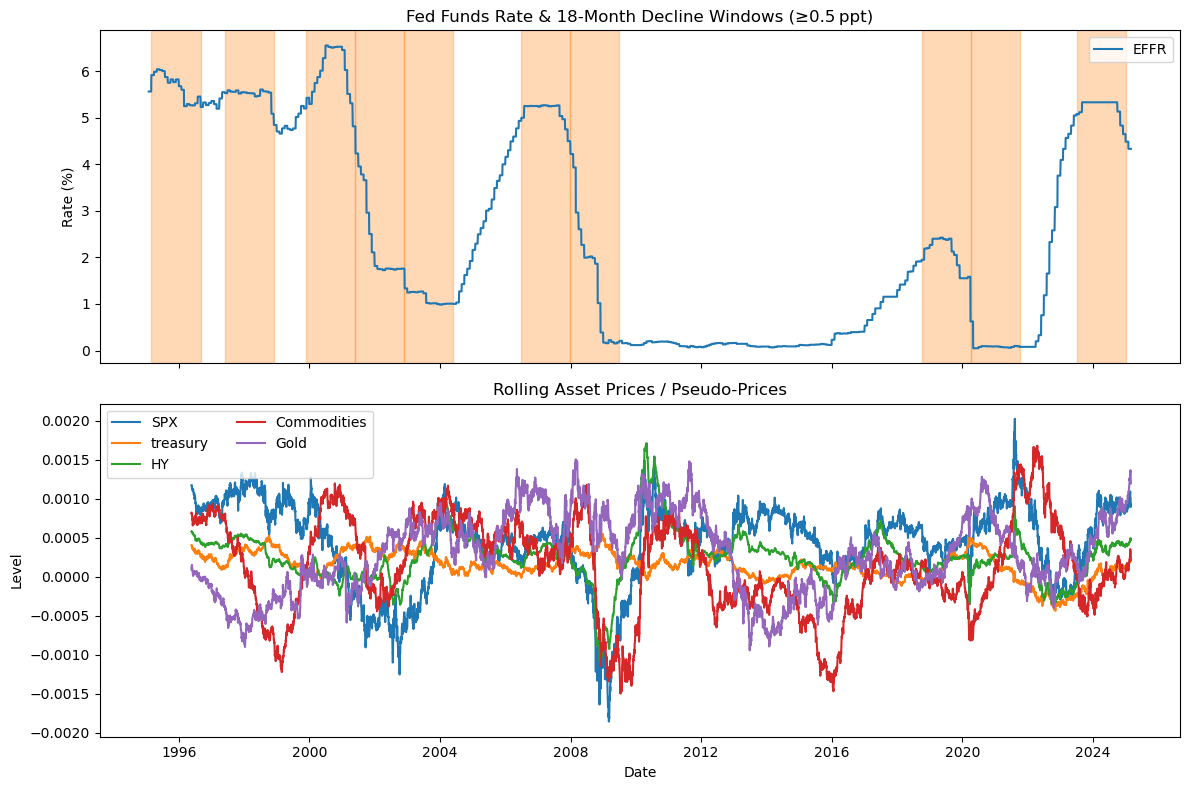

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Fed Funds with highlighted windows
ax1.plot(ff_rate.index, ff_rate.values, label='EFFR')
for d0 in regimes:
    t1 = ff_rate.index[ff_rate.index >= d0 + relativedelta(months=+HORIZON_MONTHS)][0]
    ax1.axvspan(d0, t1, color='C1', alpha=0.3)
ax1.set_title(f'Fed Funds Rate & {HORIZON_MONTHS}-Month Decline Windows (≥{DECLINE_THRESHOLD} ppt)')
ax1.set_ylabel('Rate (%)')
ax1.legend(loc='upper right')

# Bottom: Asset series
for col in asset_px.columns:
    returns = asset_px[col].pct_change().dropna().rolling(365).mean()
    ax2.plot(returns.index, returns, label=col)
ax2.set_title('Rolling Asset Prices / Pseudo‑Prices')
ax2.set_ylabel('Level')
ax2.legend(ncol=2, loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


# Problem 3

Do you think your answer to (2) makes sense to extrapolate into how investors should
behave right now? Why or why not?

No, so far in 2025 we haven’t actually seen Fed cuts, and markets are behaving more like they’re still wrestling with sticky inflation and mixed growth signals. In addition, there seems to be abnormal correlations between equities and bonds. While the meaning this is up for debate, it may be a sign that the market is "selling the US" which may bias backtesting results to favor US equities in relation to the current market environment.

